# Flappy Bird AI using Reinforce (Monte Carlo Policy Gradient)

### Importing Flappy Bird gym and other important libraries

In [41]:
import gymnasium as gym
import flappy_bird_gymnasium

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque
import numpy as np

import imageio

import matplotlib.pyplot as plt
import time

Check if we have gpu

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Making env

In [43]:
env_id = "FlappyBird-v0"    # flappy bird env id

env = gym.make(env_id, render_mode='rgb_array')      # creating the env
eval_env = gym.make(env_id, render_mode='rgb_array')     # creating the eval env
env.reset()
eval_env.reset()

s_size = env.observation_space.shape[0]     # observation space
a_size = env.action_space.n                 # action space

### Observation Space

In [44]:
print("_____OBSERVATION SPACE_____ \n")
print(f"Observation Space: {s_size}")
print(f"Sample Observation Space: {env.observation_space.sample()}")

_____OBSERVATION SPACE_____ 

Observation Space: 12
Sample Observation Space: [ 1.41926383 -0.1797221   0.97622952 -0.49104619  0.79411279 -0.56629273
 -0.58426733 -0.53222114  0.13496279  1.50129678  1.62652175 -1.60260609]


#### The Observation Space (12):
- the last pipe's horizontal position
- the last top pipe's vertical position
- the last bottom pipe's vertical position
- the next pipe's horizontal position
- the next top pipe's vertical position
- the next bottom pipe's vertical position
- the next next pipe's horizontal position
- the next next top pipe's vertical position
- the next next bottom pipe's vertical position
- player's vertical position
- player's vertical velocity
- player's rotation

In [45]:
print("_____ACTION SPACE_____ \n")
print(f"Action Space: {a_size}")
print(f"Sample Action Space: {env.action_space.sample()}")

_____ACTION SPACE_____ 

Action Space: 2
Sample Action Space: 0


#### The action space(2):
- `1`: Up (press accelerator)
- `0`: Do nothing (don't press accelerator)

### Reward Function:
- `+0.1` - every frame it stays alive
- `+1.0` - succesfully passing a pipe
- `-1.0` - dying

## Defining the Policy

In [46]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        ## Creating Layers
        # Hidden Layers
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size*2)
        # Output Layer
        self.fc3 = nn.Linear(h_size*2, a_size)

    # Define the Forward Pass
    def forward(self, x):
        # apply relu activation function to the hidden layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # output with softmax
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
    # Define the act i.e. given a state, take action
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [47]:
debug_policy = Policy(s_size, a_size, 64).to(device)
state = env.reset()
debug_policy.act(state[0])

(1, tensor([-0.6170], grad_fn=<SqueezeBackward1>))

## Building the Reinforce Algorithm
Building the Monte Carlo Policy Gradient (MCPG) or Reinforce Algorithm

In [48]:
##########
losses = []
##########
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        state = state[0]
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, terminated, truncated, info = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        returns = deque(maxlen=max_t) 
        n_steps = len(rewards) 

        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft( gamma*disc_return_t + rewards[t]   )

        # standardizing returns to make traininig more stable
        eps = np.finfo(np.float32).eps.item()       # smallest representable float
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std()+eps)    # added to std deviation to avoid numerical instabilities

        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        ########
        losses.append(policy_loss.item())
        ########
        if i_episode % print_every == 0:
            print(f"Episode: {i_episode}\tAverage Score: {np.mean(scores_deque)}\tPolicy Loss: {policy_loss.item()}")
        
    return scores

## Definig Hyperparameters

In [49]:
flappybird_hyperparameters = {
    "h_size": 32,
    "n_training_episodes": 10000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": .99,
    "lr": 1e4,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [50]:
Policy(s_size, a_size, flappybird_hyperparameters['h_size'])

Policy(
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

## Training the Agent

In [51]:
flappybird_policy = Policy(flappybird_hyperparameters["state_space"], flappybird_hyperparameters["action_space"], flappybird_hyperparameters["h_size"]).to(device)
flappybird_optimizer = optim.Adam(flappybird_policy.parameters(), lr=flappybird_hyperparameters["lr"])

In [52]:
scores = reinforce(
    flappybird_policy,
    flappybird_optimizer,
    flappybird_hyperparameters["n_training_episodes"],
    flappybird_hyperparameters["max_t"],
    flappybird_hyperparameters["gamma"],
    1000,
)

Episode: 1000	Average Score: 8.999999999999982	Policy Loss: 3.410605131648481e-13
Episode: 2000	Average Score: 8.999999999999982	Policy Loss: 3.410605131648481e-13
Episode: 3000	Average Score: 8.999999999999982	Policy Loss: 3.410605131648481e-13
Episode: 4000	Average Score: 8.999999999999982	Policy Loss: 3.410605131648481e-13
Episode: 5000	Average Score: 8.999999999999982	Policy Loss: 3.410605131648481e-13
Episode: 6000	Average Score: 8.999999999999982	Policy Loss: 3.410605131648481e-13
Episode: 7000	Average Score: 8.999999999999982	Policy Loss: 3.410605131648481e-13
Episode: 8000	Average Score: 8.999999999999982	Policy Loss: 3.410605131648481e-13
Episode: 9000	Average Score: 8.999999999999982	Policy Loss: 3.410605131648481e-13
Episode: 10000	Average Score: 8.999999999999982	Policy Loss: 3.410605131648481e-13


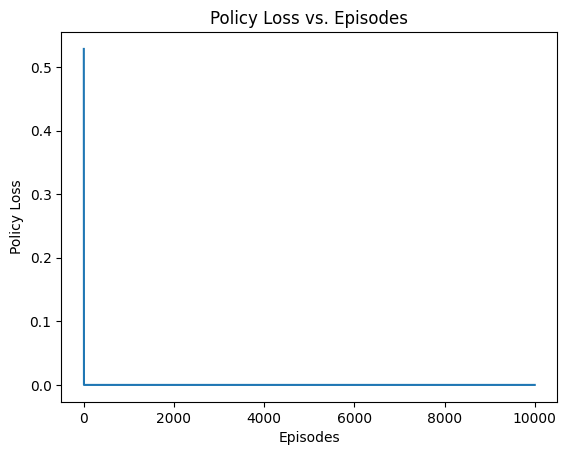

In [53]:
# Plotting the policy loss with episodes
plt.plot(range(1, flappybird_hyperparameters["n_training_episodes"]+1), losses)
plt.xlabel('Episodes')
plt.ylabel('Policy Loss')
plt.title('Policy Loss vs. Episodes')
plt.show()

## Define Evaluation Agent

In [54]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    state = state[0]
    step = 0
    terminated = False
    truncated = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward

      if terminated or truncated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

#### Evaluate our Agent

In [55]:
evaluate_agent(eval_env,
               flappybird_hyperparameters["max_t"],
               flappybird_hyperparameters["n_evaluation_episodes"],
               flappybird_policy)

(8.999999999999982, 1.7763568394002505e-15)

### Recording Video

In [56]:
def record_video(env, policy, out_directory, fps=30):
  images = []
  terminated = False
  truncated = False
  state = env.reset()
  state = state[0]
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    action, _ = policy.act(state)
    state, reward, terminated, truncated, info = env.step(action)
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [57]:
video_path = './Videos/replay.mp4'
record_video(eval_env, flappybird_policy, video_path, 30)